In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm


In [2]:
# Check for MPS (Apple Silicon) or CUDA (GPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


In [3]:
# Transforms
transform = transforms.ToTensor()

# Load datasets
full_train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Split into training and validation sets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_train_dataset, [train_size, val_size]
)

# Data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(
                1, 32, kernel_size=4, stride=2, padding=1
            ),  # Output: [batch, 32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(
                32, 64, kernel_size=4, stride=2, padding=1
            ),  # Output: [batch, 64, 7, 7]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=1),  # Output: [batch, 128, 4, 4]
            nn.ReLU(),
            nn.Flatten(),  # Output: [batch, 2048]
        )
        # Calculate size after flattening
        self.fc_input_dim = 128 * 4 * 4

        # Latent vectors mu and logvar
        self.fc_mu = nn.Linear(self.fc_input_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.fc_input_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.fc_input_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),  # Output: [batch, 128, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(
                128, 64, kernel_size=4, stride=1
            ),  # Output: [batch, 64, 7, 7]
            nn.ReLU(),
            nn.ConvTranspose2d(
                64, 32, kernel_size=4, stride=2, padding=1
            ),  # Output: [batch, 32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(
                32, 1, kernel_size=4, stride=2, padding=1
            ),  # Output: [batch, 1, 28, 28]
            nn.Sigmoid(),  # Output values between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(device)
        z = mu + eps * std
        return z

    def decode(self, z):
        h = self.fc_decode(z)
        x_recon = self.decoder(h)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

    # Loss function adjusted for Bernoulli distribution
    def loss_function(self, recon_x, x, mu, logvar):
        # Reconstruction loss (binary cross-entropy)
        BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
        # KL divergence
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD


In [5]:
model = VAE(latent_dim=2).to(device)


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")

    for batch_idx, (data, _) in enumerate(progress_bar):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        progress_bar.set_postfix({"loss": loss.item() / len(data)})

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}")

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, data, mu, logvar)
            val_loss += loss.item()
    val_loss /= len(val_loader.dataset)
    print(f"====> Validation loss: {val_loss:.4f}")


Epoch 1/10: 100%|██████████| 375/375 [00:08<00:00, 42.81it/s, loss=167]


====> Epoch: 1 Average loss: 188.8476
====> Validation loss: 166.1864


Epoch 2/10: 100%|██████████| 375/375 [00:06<00:00, 60.75it/s, loss=159]


====> Epoch: 2 Average loss: 161.0713
====> Validation loss: 158.4647


Epoch 3/10: 100%|██████████| 375/375 [00:05<00:00, 62.91it/s, loss=154]


====> Epoch: 3 Average loss: 156.3688
====> Validation loss: 155.7432


Epoch 4/10: 100%|██████████| 375/375 [00:06<00:00, 62.30it/s, loss=152]


====> Epoch: 4 Average loss: 153.8337
====> Validation loss: 152.5463


Epoch 5/10: 100%|██████████| 375/375 [00:05<00:00, 66.19it/s, loss=153]


====> Epoch: 5 Average loss: 151.9830
====> Validation loss: 151.4920


Epoch 6/10: 100%|██████████| 375/375 [00:05<00:00, 66.60it/s, loss=149]


====> Epoch: 6 Average loss: 150.5216
====> Validation loss: 151.0484


Epoch 7/10: 100%|██████████| 375/375 [00:06<00:00, 59.51it/s, loss=150]


====> Epoch: 7 Average loss: 149.4304
====> Validation loss: 149.7284


Epoch 8/10: 100%|██████████| 375/375 [00:05<00:00, 67.83it/s, loss=145]


====> Epoch: 8 Average loss: 148.5663
====> Validation loss: 149.2314


Epoch 9/10: 100%|██████████| 375/375 [00:05<00:00, 67.47it/s, loss=145]


====> Epoch: 9 Average loss: 147.7671
====> Validation loss: 148.1916


Epoch 10/10: 100%|██████████| 375/375 [00:05<00:00, 67.37it/s, loss=148]


====> Epoch: 10 Average loss: 147.0958
====> Validation loss: 147.7368


In [7]:
# Collect latent variables and labels
latents = []
labels = []

model.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(val_loader):
        data = data.to(device)
        mu, _ = model.encode(data)
        latents.append(mu.cpu())
        labels.append(target.cpu())

latents = torch.cat(latents)
labels = torch.cat(labels)


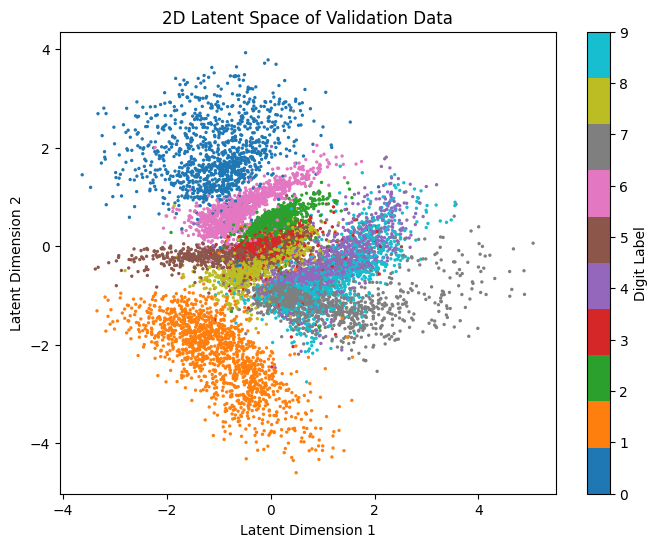

In [8]:
# Plot the latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap="tab10", s=2)
plt.colorbar(scatter, ticks=range(10), label="Digit Label")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space of Validation Data")
plt.show()


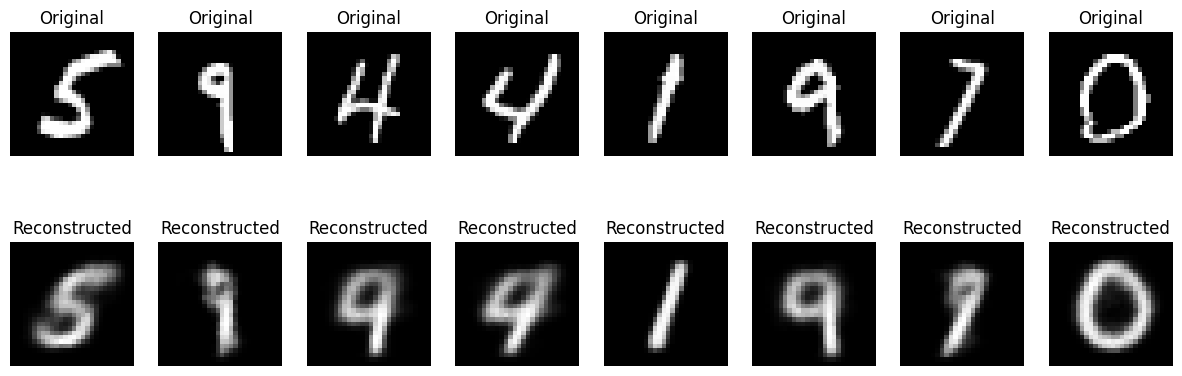

In [9]:
# Prepare test data loader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Get a batch of test images
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)

# Reconstruct images
model.eval()
with torch.no_grad():
    recon_images, _, _ = model(images)

# Move to CPU for visualization
images = images.cpu()
recon_images = recon_images.cpu()


# Function to plot images
def plot_images(original, reconstructed, num_images=8):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].squeeze(), cmap="gray")
        ax.set_title("Original")
        ax.axis("off")

        # Reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].squeeze(), cmap="gray")
        ax.set_title("Reconstructed")
        ax.axis("off")
    plt.show()


# Plot original and reconstructed images
plot_images(images, recon_images)